In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_default_device(device)

In [3]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [6]:
def nametotensor(name):
    # make sure name is ascii coded
    name = unicodeToAscii(name)
    zero_tensor = torch.zeros(1, len(allowed_characters))
    tensor_list = []
    # we assume a name has at least two letters
    for idx, letter in enumerate(name):
        letter_idx = allowed_characters.index(letter)
        letter_tensor = zero_tensor.clone()
        letter_tensor[0][letter_idx] = 1
        tensor_list.append(letter_tensor)
    return torch.stack(tensor_list)

In [7]:
from torch.utils.data import Dataset
import glob 
import os 

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path 
        self.names = []
        self.namestensors = []
        self.labels = []

        file_names = glob.glob(os.path.join(data_path, "*.txt"))
        for file in file_names:
            print(f"{file} processed")
            label = os.path.basename(file).split(".")[0]
            names = open(file).read().strip().split("\n")
            self.names.extend(names)
            self.namestensors.extend([nametotensor(name) for name in self.names])
            self.labels.extend([label] * len(names))
            print(f"Number of {label} names: {len(names)}")
        # get label tensors 
        self.uniq_labels = list(set(self.labels))
        self.labelstensors = [torch.tensor([self.uniq_labels.index(l)], dtype=torch.long) for l in self.labels]

    def __len__(self):
        return len(self.names)
        
    def __getitem__(self, idx):
        name, nametensor = self.names[idx], self.namestensors[idx]
        label, labeltensor = self.labels[idx], self.labelstensors[idx]
        return labeltensor, nametensor, label, name


In [8]:
data = MyDataset("data/names")

data/names/Korean.txt processed
Number of Korean names: 94
data/names/Irish.txt processed
Number of Irish names: 232
data/names/Portuguese.txt processed
Number of Portuguese names: 74
data/names/Vietnamese.txt processed
Number of Vietnamese names: 73
data/names/Czech.txt processed
Number of Czech names: 519
data/names/Russian.txt processed
Number of Russian names: 9408
data/names/Scottish.txt processed
Number of Scottish names: 100
data/names/German.txt processed
Number of German names: 724
data/names/Polish.txt processed
Number of Polish names: 139
data/names/Spanish.txt processed
Number of Spanish names: 298
data/names/English.txt processed
Number of English names: 3668
data/names/French.txt processed
Number of French names: 277
data/names/Japanese.txt processed
Number of Japanese names: 991
data/names/Dutch.txt processed
Number of Dutch names: 297
data/names/Greek.txt processed
Number of Greek names: 203
data/names/Chinese.txt processed
Number of Chinese names: 268
data/names/Italia

In [9]:
# quick snap into the first element 
data[0]

(tensor([12], device='cuda:0'),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0'),
 'Korean',
 'Ahn')

In [10]:
# train-test split
train_data, test_data = torch.utils.data.random_split(data, [0.8, 0.2], 
                                                     generator=torch.Generator(device=device).manual_seed(2024))

In [13]:
# number of samples per language in the training data
class_count = {c: 0 for c in data.uniq_labels}
for item in train_data:
    class_count[item[2]] += 1

class_count

{'Russian': 7527,
 'Scottish': 80,
 'English': 2950,
 'French': 231,
 'Czech': 392,
 'Irish': 200,
 'German': 588,
 'Polish': 110,
 'Arabic': 1599,
 'Dutch': 223,
 'Italian': 562,
 'Greek': 159,
 'Korean': 76,
 'Spanish': 229,
 'Portuguese': 60,
 'Japanese': 799,
 'Vietnamese': 56,
 'Chinese': 219}

# Multi-layer Elman-RNN Architecture

Unlike in the reference doc, we are going to explicitly show the forward method in our multi-layer RNN. We define multi-layer weights through `Parameter`. 

In [86]:
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn import init

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 4):
        super().__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # define weights and biases
        self.W_ih = Parameter(torch.empty(self.num_layers, self.hidden_size, self.hidden_size))
        self.b_ih = Parameter(torch.empty(self.num_layers, self.hidden_size))
        self.W_hh = Parameter(torch.empty(self.num_layers, self.hidden_size, self.hidden_size))
        self.b_hh = Parameter(torch.empty(self.num_layers, self.hidden_size))    

        # weight initialization
        for i in range(self.num_layers):
            # For the first layer, W_ih uses input_size
            init.xavier_uniform_(self.W_ih[i]) # Slicing to match actual input_size
            init.zeros_(self.b_ih[i])
            init.xavier_uniform_(self.W_hh[i])
            init.zeros_(self.b_hh[i])
            
        # output layers
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
            
    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        h_states = torch.zeros((self.num_layers, batch_size, self.hidden_size), requires_grad=False)
        outputs = []
        for t in range(seq_len):
            new_h_states = []
            for layer in range(self.num_layers):
                # only the first layer takes the corresponding input
                if layer == 0:
                    new_h = torch.tanh(x[t] @ self.W_ih[layer, :, :self.input_size].T + self.b_ih[layer] + h_states[layer] @ self.W_hh[layer].T + self.b_hh[layer])
                else:
                    new_h = torch.tanh(new_h_states[layer-1] @ self.W_ih[layer].T + self.b_ih[layer] + h_states[layer] @ self.W_hh[layer].T + self.b_hh[layer] )    
                new_h_states.append(new_h)
            # we are interested in the output of the last layer 
            h_states = new_h_states
            outputs.append(new_h)
            
        logits = self.fc(h_states[-1])
        log_softs = self.softmax(logits)
        return outputs, log_softs

Let's run our RNN on the first name without any training:

In [87]:
input_size = len(allowed_characters)
hidden_size = 64
output_size = len(data.uniq_labels)
myrnn = MyRNN(input_size, hidden_size, output_size)
first_example = data[0]
print("running on the name:", data[0][3])
outputs, probs = myrnn(data[0][1])
print("log softmax values are:", probs)

running on the name: Ahn
log softmax values are: tensor([[-3.0636, -2.6362, -3.0419, -2.6307, -2.9870, -3.0745, -2.8783, -2.9737,
         -2.7727, -3.0600, -3.0849, -3.0805, -2.8419, -2.8908, -2.9159, -2.5999,
         -2.7737, -2.9544]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


Now, we are ready to define the usual training process. Note that, however, we introduce `nn.utils.clip_grad_norm`, which clips gradients due to vanishing/exploding gradient problem which can famously occur in RNNs.

In [88]:
import random 
import numpy as np

def training(model, training_data, n_epochs=2, batch_size=16, learning_rate=0.15, show_freq=100):

    all_losses = []
    all_probs = []
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    batch_losses = {}
    loss = nn.NLLLoss()
    for i in range(n_epochs):
        current_loss = 0
        batch_losses[i] = []
        # make sure grad is zero at each epoch
        model.zero_grad()
        model.to(device)

        # we create batches based on indexes
        indexes = list(range(len(training_data)))
        random.shuffle(indexes)
        batch_indexes = np.array_split(indexes, len(indexes) // batch_size)
        current_batch = 1
        for batch in batch_indexes:
            batch_loss = 0
            for b_idx in batch: # for each example in the current batch
                label_tensor, name_tensor, label, name = training_data[b_idx]
                name_tensor, label_tensor = name_tensor.to(device), label_tensor.to(device)
                outputs, probs = model(name_tensor)
                all_probs.append(probs)
                batch_loss += loss(probs, label_tensor)
            batch_losses[i].append(batch_loss.item() / len(batch))
            current_loss += batch_loss.item() / len(batch)
            batch_loss.backward()
            # clip!
            nn.utils.clip_grad_norm_(model.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            
            if current_batch % show_freq == 0:
                print(f"batch {current_batch} completed")
                print(f"current loss: {batch_loss.item() / len(batch)}")
                print("predicted class:", torch.argmax(probs))
            current_batch += 1
        all_losses.append(current_loss / len(batch_indexes))
    return all_losses, batch_losses
    

Train for 5 epochs:

In [89]:
torch.autograd.set_detect_anomaly(False)

In [92]:
# just to make sure, we're running the model from zero 
myrnn = MyRNN(input_size, hidden_size, output_size)
# I also track the predicted class after each showed loss to see if predictions make sense
all_losses, batch_losses = training(myrnn, train_data, n_epochs=5, show_freq=100)

batch 100 completed
current loss: 1.7249159812927246
predicted class: tensor(0, device='cuda:0')
batch 200 completed
current loss: 2.0640645027160645
predicted class: tensor(0, device='cuda:0')
batch 300 completed
current loss: 1.9869155883789062
predicted class: tensor(0, device='cuda:0')
batch 400 completed
current loss: 1.4847898483276367
predicted class: tensor(0, device='cuda:0')
batch 500 completed
current loss: 2.183243751525879
predicted class: tensor(0, device='cuda:0')
batch 600 completed
current loss: 1.8978204727172852
predicted class: tensor(6, device='cuda:0')
batch 700 completed
current loss: 1.0779480934143066
predicted class: tensor(2, device='cuda:0')
batch 800 completed
current loss: 1.859932780265808
predicted class: tensor(8, device='cuda:0')
batch 900 completed
current loss: 0.9942817687988281
predicted class: tensor(0, device='cuda:0')
batch 1000 completed
current loss: 1.7616959810256958
predicted class: tensor(8, device='cuda:0')
batch 100 completed
current los

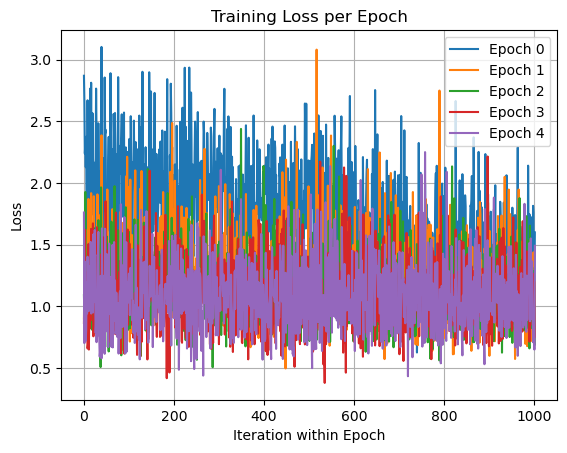

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Plot data for each epoch
for epoch, losses in batch_losses.items():
    iterations = range(len(losses))
    ax.plot(iterations, losses, label=f"Epoch {epoch}")

# Add labels, title, legend, and grid
ax.set_xlabel("Iteration within Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss per Epoch")
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [94]:
num_of_classes = len(data.uniq_labels)
confusion_matrix = torch.zeros((num_of_classes, num_of_classes))
myrnn.eval()
for idx, item in enumerate(test_data):
    outputs, probs = myrnn(item[1])
    pred_idx = torch.argmax(probs)
    true_idx = item[0].item()
    confusion_matrix[true_idx][pred_idx] += 1

In [95]:
normalized_conf = torch.empty(confusion_matrix.shape)
for idx, row in enumerate(confusion_matrix):
    if row.sum() > 0:
        normalized_conf[idx] = confusion_matrix[idx] / row.sum()

confusion matrix for the classes. As a reference, 

In [99]:
# number of samples per language in the training data
class_count = {c: 0 for c in data.uniq_labels}
for item in test_data:
    class_count[item[2]] += 1

class_count

{'Russian': 1881,
 'Scottish': 20,
 'English': 718,
 'French': 46,
 'Czech': 127,
 'Irish': 32,
 'German': 136,
 'Polish': 29,
 'Arabic': 401,
 'Dutch': 74,
 'Italian': 147,
 'Greek': 44,
 'Korean': 18,
 'Spanish': 69,
 'Portuguese': 14,
 'Japanese': 192,
 'Vietnamese': 17,
 'Chinese': 49}

<Axes: >

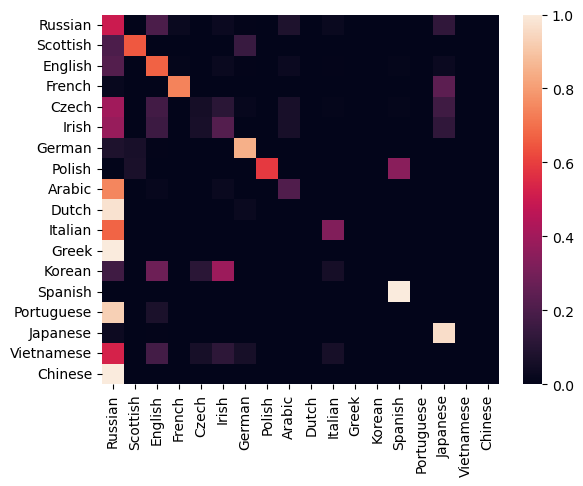

In [102]:
import seaborn as sn
sn.heatmap(normalized_conf.cpu(), xticklabels=data.uniq_labels, yticklabels=data.uniq_labels)